# < 2. 없다면 어떻게 될까? >

## 실습목표
- 직접 ResNet 구현하기
- 모델을 config에 따라서 변경 가능하도록 만들기
- 직접 실험해서 성능 비교하기

## 학습내용
- Ablation Study
- CIFAR-10 데이터셋 준비
- 블록 구성
- VGG Complete Model
- VGG-16 vs VGG-19
- ResNet Ablation Study

---

## 2.2 Ablation Study

저희가 지금부터 해볼 프로젝트는 `애블레이션 연구(ablation study)`입니다. 직역하자면 '제거 연구'정도가 되겠네요.

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다.

아래는 ResNet 논문에서 제시한 residual connection의 애블레이션 연구입니다. 이미지넷(ImageNet) 검증 데이터셋(validation dataset)에 대한 Top-1 error rate을 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교하였습니다. 이 비교를 통해서 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명하고 있습니다.

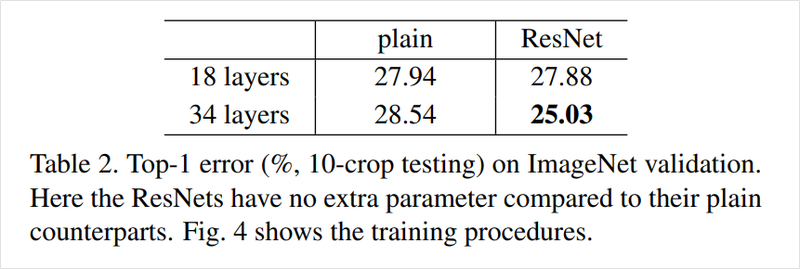

---

## 2.3 Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기
지금부터 우리의 실험은 CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인하는 것입니다.

### 1) CIFAR-10

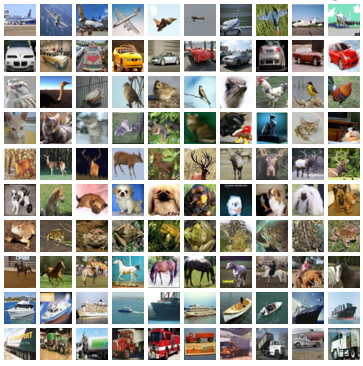

CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# GPU 장착 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


> Tensorflow의 데이터셋은 Numpy가 아니므로 `ds_train.shape`같은게 존재하지 않는다

### 2) Input Normalization

Data Normalization 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것입니다. 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값을 가지게 될 거예요. 위의 예를 수식으로 간단하게 쓴다면, (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값) 이죠.

Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는(학습 속도 향상) 거예요.

아래 그림을 보면 왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다는 것을 직관적으로 이해할 수 있습니다.그리고 scikit-learn에서 MinMaxScaler로 쉽게 사용 할 수 있어요.

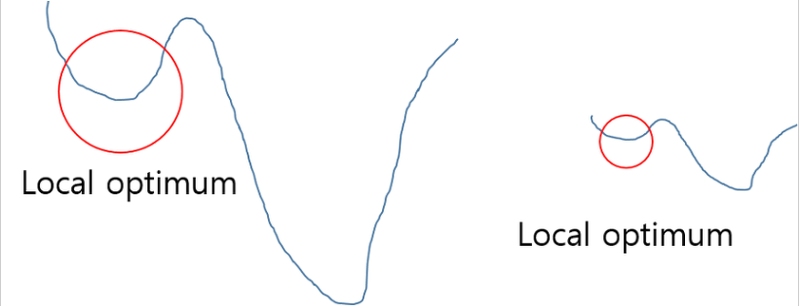

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다



In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

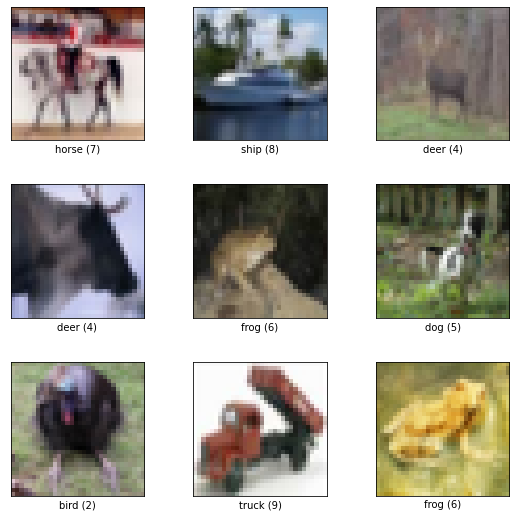

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

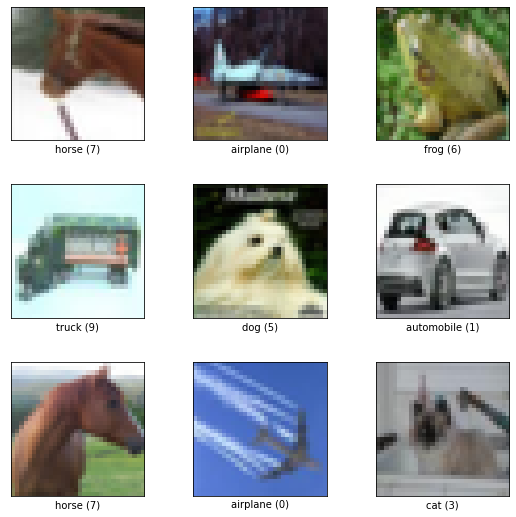

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

---

## 2.4 Ablation Study 실습 (2) 블록 구성하기

모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요합니다.

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 `블록(block)` 이라고 부릅니다. `레이어(layer)` 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위입니다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 합니다.



### VGG 기본 블록 만들기

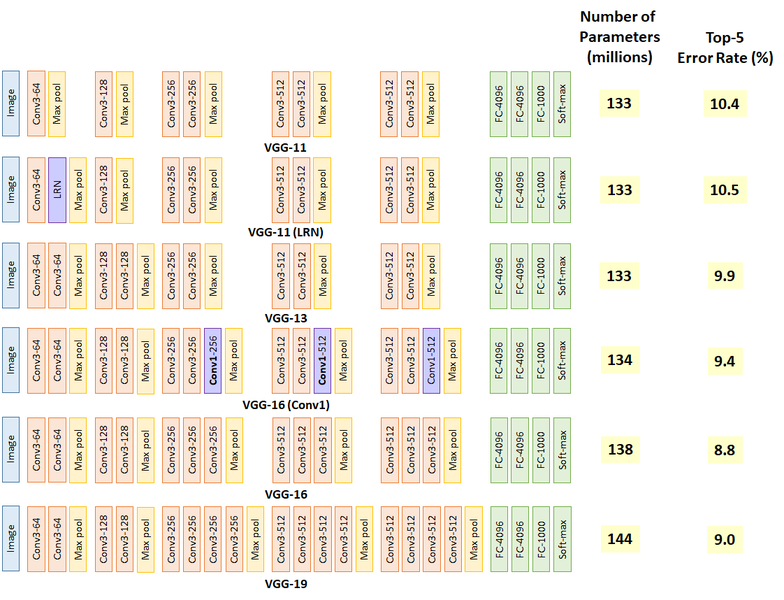

블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다. VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다. CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다. 블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

`block_num`은 레이어의 이름을 붙여주기 위해서 추가되었고 `input_shape`는 summary를 출력하기 위해서 넣어주었습니다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 input_layer 에 추가를 해 봅시다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 (32,32,3) 이 됩니다. 이 입력 레이어를 인자로 받아 build_vgg_block() 는 블록의 레이어를 build하고 출력값을 얻을 수 있습니다. 이제 케라스의 Model 클래스에서 input과 output을 정의해 주면 간단히 블록의 모델을 확인해볼 수 있습니다.

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [15]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


---

## 2.5 Ablation Study 실습 (3) VGG Complete Model

### 1) VGG-16

In [16]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19

In [19]:
vgg_19 = build_vgg(
    num_cnn_list = [2,2,4,4,4],
    channel_list = [64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

---

## 2.6 Ablation Study 실습 (4) VGG-16 vs VGG-19

In [20]:
BATCH_SIZE = 256
EPOCH = 15

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 68s 132ms/step - loss: 2.1938 - accuracy: 0.1848 - val_loss: 2.1352 - val_accuracy: 0.2006
Epoch 2/15
195/195 [==============================] - 25s 129ms/step - loss: 2.0082 - accuracy: 0.2723 - val_loss: 1.9395 - val_accuracy: 0.3168
Epoch 3/15
195/195 [==============================] - 23s 120ms/step - loss: 1.8841 - accuracy: 0.3200 - val_loss: 1.7948 - val_accuracy: 0.3484
Epoch 4/15
195/195 [==============================] - 24s 122ms/step - loss: 1.7727 - accuracy: 0.3642 - val_loss: 1.6868 - val_accuracy: 0.4072
Epoch 5/15
195/195 [==============================] - 24s 122ms/step - loss: 1.6829 - accuracy: 0.3935 - val_loss: 1.6168 - val_accuracy: 0.4179
Epoch 6/15
195/195 [==============================] - 24s 121ms/step - loss: 1.6087 - accuracy: 0.4218 - val_loss: 1.5751 - val_accuracy: 0.4368
Epoch 7/15
195/195 [==============================] - 24s 122ms/step - loss: 1.5636 - accuracy: 0.4331 - val_loss: 1.5266 - val_ac

In [23]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 33s 144ms/step - loss: 2.2324 - accuracy: 0.1629 - val_loss: 2.1562 - val_accuracy: 0.2103
Epoch 2/15
195/195 [==============================] - 28s 143ms/step - loss: 2.0890 - accuracy: 0.2313 - val_loss: 2.0287 - val_accuracy: 0.2791
Epoch 3/15
195/195 [==============================] - 27s 141ms/step - loss: 1.9448 - accuracy: 0.2951 - val_loss: 1.8863 - val_accuracy: 0.3066
Epoch 4/15
195/195 [==============================] - 28s 143ms/step - loss: 1.8224 - accuracy: 0.3436 - val_loss: 1.7439 - val_accuracy: 0.3875
Epoch 5/15
195/195 [==============================] - 28s 142ms/step - loss: 1.7255 - accuracy: 0.3777 - val_loss: 1.6905 - val_accuracy: 0.3931
Epoch 6/15
195/195 [==============================] - 28s 143ms/step - loss: 1.6555 - accuracy: 0.4041 - val_loss: 1.6165 - val_accuracy: 0.4333
Epoch 7/15
195/195 [==============================] - 28s 142ms/step - loss: 1.6019 - accuracy: 0.4215 - val_loss: 1.5799 - val_ac

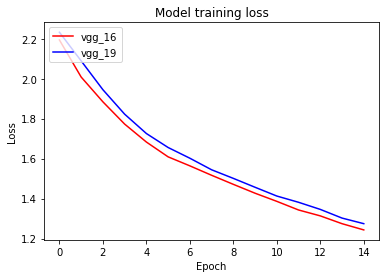

In [24]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

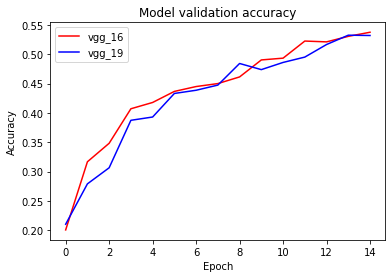

In [25]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()